# Autoencoders

> Autoencoders

Adapted from:
- https://youtu.be/0Hi2r4CaHvk?si=GA9KaGAnGOlS_NJO&t=3568

In [1]:
# |default_exp autoencoders

In [2]:
# |export
import torch
import torch.nn.functional as F
from torch import nn, optim
from tqdm import tqdm

from slowai.convs import conv, def_device, fashion_mnist, to_device
from slowai.datasets import show_images

Autoencoders learn a bottleneck representation that can be "reversed" to reconstruct the original image.

![](https://miro.medium.com/v2/resize:fit:600/1*nqzWupxC60iAH2dYrFT78Q.png)

Typically, they are not used on their own but are used to produce compressed representations.

We've seen how a convolutional neural network can produce a simple representation of an image: that is, the categorical probability distribution over all the fashion classes. How do reverse this process to reconstruct the original image.

Transpose or "Stride $\frac{1}{2}$"  convolutions work, but this notebook focuses on the [nearest neighbor upsampling](https://pytorch.org/docs/stable/generated/torch.nn.UpsamplingNearest2d.html). This upsamples the activations from the previous layer and applies a convolutional layer to restore detail.

In [3]:
# |export
def deconv(c_in, c_out, ks=3, act=True):
    layers = [
        nn.UpsamplingNearest2d(scale_factor=2),
        nn.Conv2d(c_in, c_out, stride=1, kernel_size=ks, padding=ks // 2),
    ]
    if act:
        layers.append(nn.ReLU())
    return nn.Sequential(*layers)

We need to modify the `fit` function because the loss function is no longer of the label.

In [4]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, tqdm_=False):
    """Modified fit function for reconstruction tasks"""
    progress = tqdm if tqdm_ else lambda x: x
    for epoch in range(epochs):
        model.train()
        trn_loss, trn_count = 0.0, 0
        for xb, _ in progress(train_dl):
            xb = to_device(xb)
            loss = loss_func(model(xb), xb)  # 👈
            bs, *_ = xb.shape
            trn_loss += loss.item() * bs
            trn_count += bs
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            tst_loss, tot_acc, tst_count = 0.0, 0.0, 0
            for xb, _ in progress(valid_dl):
                xb = to_device(xb)
                pred = model(xb)
                bs, *_ = xb.shape
                tst_count += bs
                tst_loss += loss_func(pred, xb).item() * bs

        print(
            f"{epoch=}: trn_loss={trn_loss / trn_count:.3f}, tst_loss={tst_loss / tst_count:.3f}"
        )

In [5]:
# |export
def get_model():
    # input.shape[:2] == 28x28
    return nn.Sequential(
        nn.ZeroPad2d(padding=2),  # 32x32
        conv(1, 2),  # 16x16
        conv(2, 4),  # 8x8
        conv(4, 8),  # 4x4
        deconv(8, 4),  # 8x8
        deconv(4, 2),  # 16x16
        deconv(2, 1, act=False),  # 32x32
        nn.ZeroPad2d(padding=-2),  # 28x28
        nn.Sigmoid(),
    ).to(def_device)

In [6]:
autoencoder = get_model()
autoencoder

Sequential(
  (0): ZeroPad2d((2, 2, 2, 2))
  (1): Sequential(
    (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(2, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Sequential(
    (0): UpsamplingNearest2d(scale_factor=2.0, mode='nearest')
    (1): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
  )
  (5): Sequential(
    (0): UpsamplingNearest2d(scale_factor=2.0, mode='nearest')
    (1): Conv2d(4, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
  )
  (6): Sequential(
    (0): UpsamplingNearest2d(scale_factor=2.0, mode='nearest')
    (1): Conv2d(2, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (7): ZeroPad2d((-2, -2, -2, -2))
  (8): Sigmoid()
)

In [7]:
with fashion_mnist() as (_, tst_dl):
    xb, _ = next(iter(tst_dl))

In [8]:
assert xb.shape == autoencoder(xb.to(def_device)).shape

In [12]:
model = get_model()
with fashion_mnist() as dls:
    opt = optim.AdamW(model.parameters(), lr=0.01)
    fit(10, model, F.mse_loss, opt, *dls)

epoch=0: trn_loss=0.052, tst_loss=0.028
epoch=1: trn_loss=0.024, tst_loss=0.021
epoch=2: trn_loss=0.020, tst_loss=0.019
epoch=3: trn_loss=0.019, tst_loss=0.018
epoch=4: trn_loss=0.018, tst_loss=0.018
epoch=5: trn_loss=0.018, tst_loss=0.018
epoch=6: trn_loss=0.018, tst_loss=0.018
epoch=7: trn_loss=0.017, tst_loss=0.017
epoch=8: trn_loss=0.017, tst_loss=0.018
epoch=9: trn_loss=0.017, tst_loss=0.017


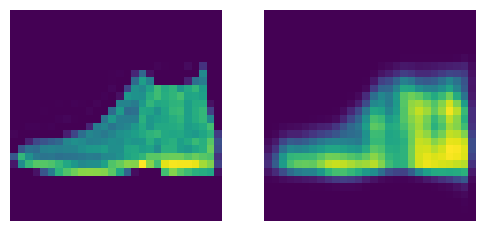

In [13]:
pred = model(xb.to(def_device))
show_images([xb[0, ...].squeeze(), pred[0, ...].squeeze()])

That looks...not great.

At this point, Jeremy pauses to go over building a framework to iterate on this problem more quickly. Continued in the next notebook.

In [11]:
# |hide
import nbdev

nbdev.nbdev_export()